
# 神经元

深度学习的核心是神经网络，即能够通过简单函数的组合来表示复杂函数的数学实体。人工和生理（physiological）神经网络似乎使用的是略微相似的数学策略来近似复杂的函数，因为这种策略很有效。


这些复杂函数的基本组成单元是神经元，如图所示。从本质上讲，神经元不过是输入的线性变换（例如，输入乘以一个数[weight，权重]，再加上一个常数[偏置，bias]），然后再经过一个固定的非线性函数（称为激活函数）。

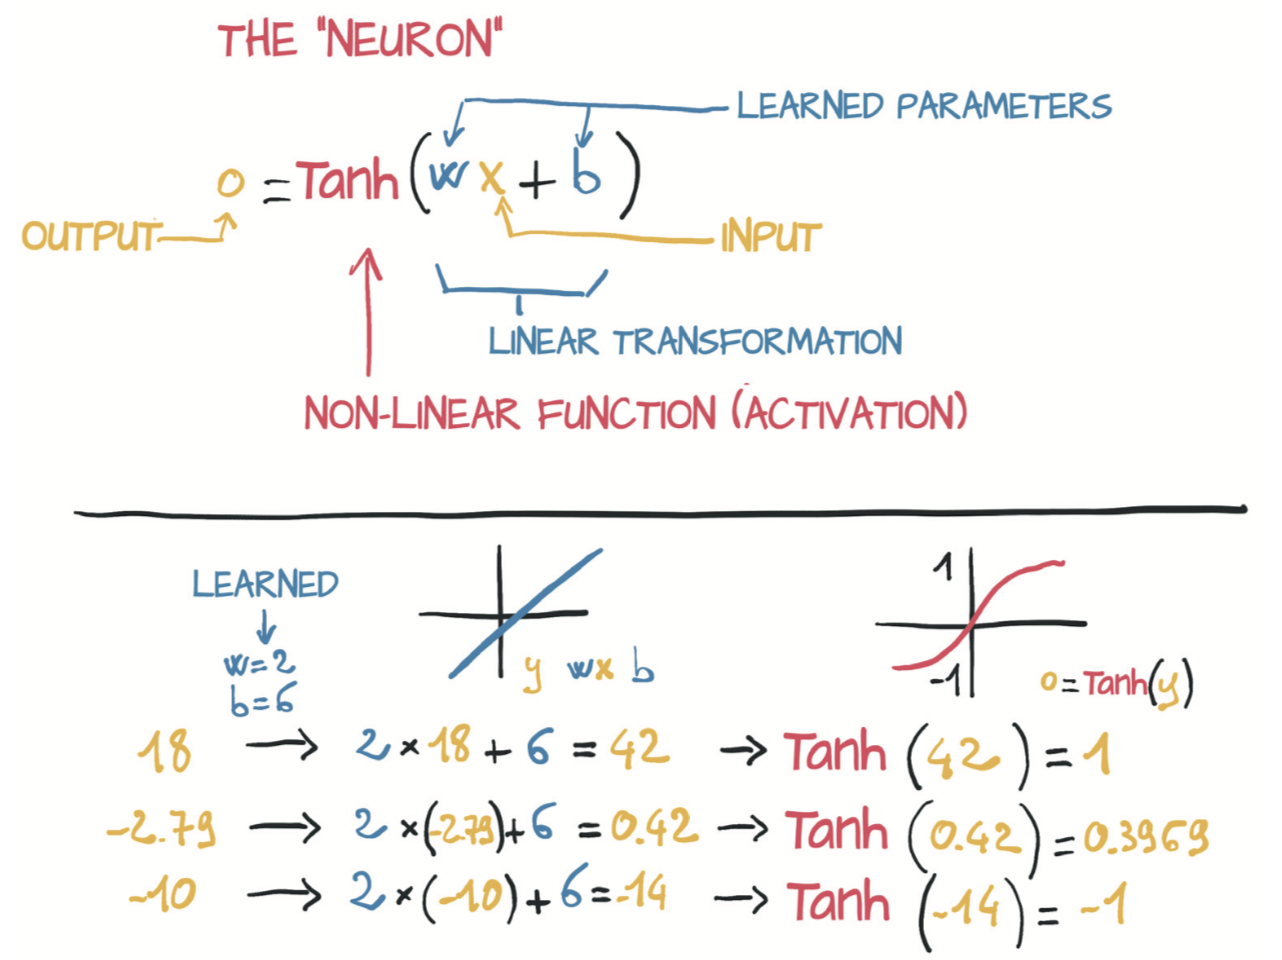
数学上，你可以将其写为 $o=f(wx+b)$，其中 $x$ 为输入，$w$ 为权重或缩放因子，$b$ 为偏置或偏移。$f$ 是激活函数，在此处设置为双曲正切（tanh）函数。通常，$x$ 以及 $o$ 可以是简单的标量，也可以是向量（包含许多标量值）。类似地，$w$ 可以是单个标量或矩阵，而 $b$ 是标量或向量（输入和权重的维度必须匹配）。在后一种情况下，该表达式被称为神经元层，因为它通过多维度的权重和偏差表示许多神经元。

如下图所示的多层神经网络例子由下面的函数组成：

$$
\begin{aligned}
x_1 &= f(w_0x + b_0) \\
x_2 &= f(w_1x_1 + b_1) \\
... \\
y &= f(w_nx_n + b_n)
\end{aligned}
$$

其中神经元层的输出将用作下一层的输入。请记住，这里的 $w_0$ 是一个矩阵，而 $x$ 是一个向量！在此使用向量可使 $w_0$ 容纳整个神经元层，而不仅仅是单个权重。
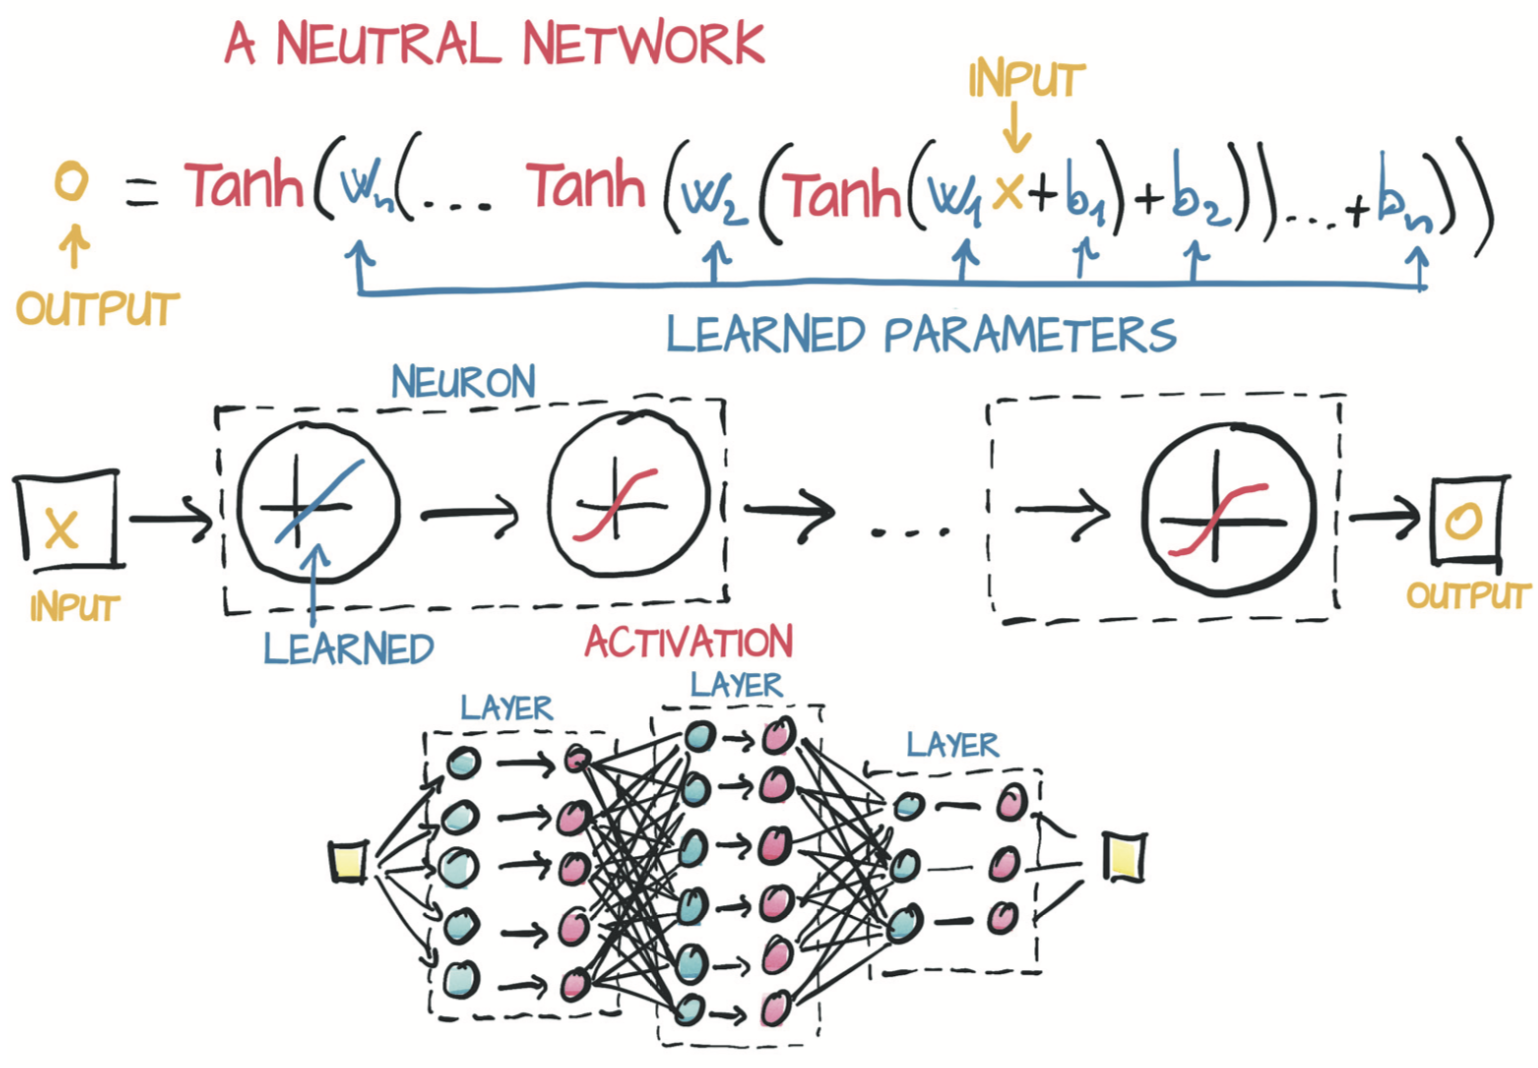

之前的线性模型与你将要使用的深度学习模型之间的重要区别是误差函数的形状。线性模型和误差平方损失函数具有凸的具有明确定义的最小值的误差曲线。如果你要使用非梯度下降的方），则可以自动地求出这个明确的最小值。而使用梯度下降参数更新则试图尽可能地估计出这个最小值。

即使使用相同的误差平方损失函数，神经网络也不具有凸误差曲面这个属性。

神经网络具有非凸误差曲面主要是因为激活函数。组合神经元来逼近各种复杂函数的能力取决于每个神经元固有的线性和非线性行为的组合。


#  PyTorch的nn模块  

<style>  
  h1 {  
    color: #2c3e50;  
    font-size: 22px;  
  }  
  h2 {  
    color: #34495e;  
    font-size: 20px;  
  }  
  p {  
    font-size: 16px;  
    color: #7f8c8d;  
  }  
  li {  
    font-size: 14px;  
    color: #95a5a6;  
  }  
</style>  

## 神经网络运算流程  

神经网络运算主要包含**训练 \(training\)**和**预测 \(predict/inference\)**两个阶段：  

1. **训练的基本流程**：
   - 输入数据 -> 网络层前向传播 -> 计算损失 -> 网络层反向传播梯度 -> 更新参数  

2. **预测的基本流程**：  
   - 输入数据 -> 网络层前向传播 -> 输出结果  

从运算的角度看，主要可以分为以下三种类型的计算：  

### 数据在网络层之间的流动  

**前向传播**和**反向传播**可以看做是**张量 (Tensor)** 在网络层之间的流动（前向传播流动的是输入输出，反向传播流动的是梯度）。每个网络层进行一定的运算，然后将结果输入到下一层。  

### 计算损失  

衔接前向和反向传播的中间过程，定义模型的输出与真实值之间的差异，提供反向传播所需的信息。  

### 参数更新  

使用计算得到的梯度对网络参数进行更新。  


基于这三种类型的计算，我们可以对网络的基本组件做一个抽象：  

- **张量 \(Tensor\)**：  
  神经网络中数据的基本单位。  

- **网络层 \(Layer\)**：  
  负责接收上一层的输入，进行该层的运算，将结果输出给下一层。由于张量的流动有前向和反向两个方向，因此对于每种类型网络层，我们都需要同时实现 `forward` 和 `backward` 两种运算。  

- **损失 \(Loss\)**：  
  在给定模型预测值与真实值之后，该组件输出损失值以及关于最后一层的梯度（用于梯度回传）。  

- **优化器 \(Optimizer\)**：  
  负责使用梯度更新模型的参数。

然后我们还需要一些组件把上述这四种基本组件整合到一起，形成一个**pipeline**：  

 **Net 组件**：负责管理张量在网络层之间的前向和反向传播，并提供获取参数、设置参数、获取梯度的接口。  

 **Model 组件**：负责整合所有组件，形成整个 pipeline。即 Net 组件进行前向传播 -> Losses 组件计算损失和梯度 -> Net 组件将梯度反向传播 -> Optimizer 组件将梯度更新到参数。  


### 基本的框架图如下图  
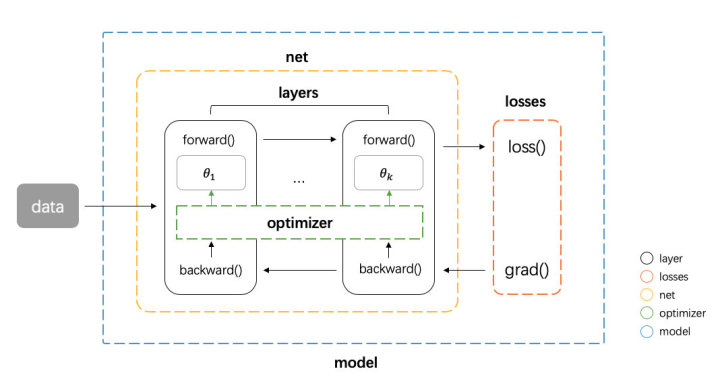

之前首次介绍神经网络时，我们关注的是具有单一输出的线性模型。 在这里，整个模型只有一个输出。 注意，单个神经网络 ：
（1）接受一些输入； 
（2）生成相应的标量输出； 
（3）具有一组相关参数（parameters），更新这些参数可以优化某目标函数。

然后，当考虑具有多个输出的网络时， 我们利用矢量化算法来描述整层神经元。 像单个神经元一样，层（1）接受一组输入， （2）生成相应的输出， （3）由一组可调整参数描述。 当我们使用softmax回归时，一个单层本身就是模型。 然而，即使我们随后引入了多层感知机，我们仍然可以认为该模型保留了上面所说的基本架构。

对于多层感知机而言，整个模型及其组成层都是这种架构。 整个模型接受原始输入（特征），生成输出（预测）， 并包含一些参数（所有组成层的参数集合）。 同样，每个单独的层接收输入（由前一层提供）， 生成输出（到下一层的输入），并且具有一组可调参数， 这些参数根据从下一层反向传播的信号进行更新。

事实证明，研究讨论“比单个层大”但“比整个模型小”的组件更有价值。 例如，在计算机视觉中广泛流行的ResNet-152架构就有数百层， 这些层是由层组（groups of layers）的重复模式组成。 这个ResNet架构赢得了2015年ImageNet和COCO计算机视觉比赛 的识别和检测任务 (He et al., 2016)。 目前ResNet架构仍然是许多视觉任务的首选架构。 在其他的领域，如自然语言处理和语音， 层组以各种重复模式排列的类似架构现在也是普遍存在。

为了实现这些复杂的网络，我们引入了神经网络块的概念。 块（block）可以描述单个层、由多个层组成的组件或整个模型本身。 使用块进行抽象的一个好处是可以将一些块组合成更大的组件， 这一过程通常是递归的，如下图所示。 通过定义代码来按需生成任意复杂度的块， 我们可以通过简洁的代码实现复杂的神经网络。

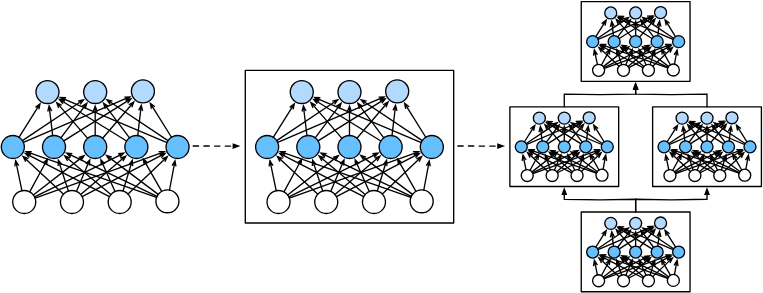


PyTorch有一个专门用于神经网络的完整子模块:torch.nn。该子模块包含创建各种神经网络体系结构所需的构建块。这些构建块在PyTorch术语中称为module(模块),在其他框架中称为layer(层)。  

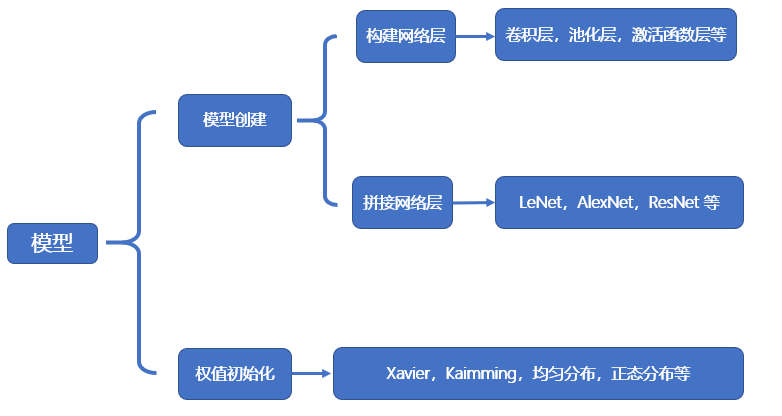

PyTorch模块都是从基类nn.Module继承而来的Python类。模块可以具有一个或多个参数(Parameter)实例作为属性,这些参数就是在训练过程中需要优化的张量(在之前的线性模型中即w和b)。模块还可以具有一个或多个子模块(nn.Module的子类)属性,并且也可以追踪其参数。  

注:子模块必须是顶级属性(top-level attributes),而不能包含在list或dict实例中!否则,优化器将无法找到子模块(及其参数)。对于需要子模块列表或字典的情况,PyTorch提供有nn.ModuleList和nn.ModuleDict。  

你可以毫不奇怪地可以找到一个名为nn.Linear的nn.Module子类,它对其输入进行仿射变换(通过参数属性weight和bias);它就相当于之前在温度计实验中实现的方法。现在,从上次中断的地方开始,将之前的代码转换为使用nn的形式。  

所有PyTorch提供的nn.Module子类都定义了其调用方法,使你可以实例化nn.Linear并将其像一个函数一样进行调用,如下面的代码所示:

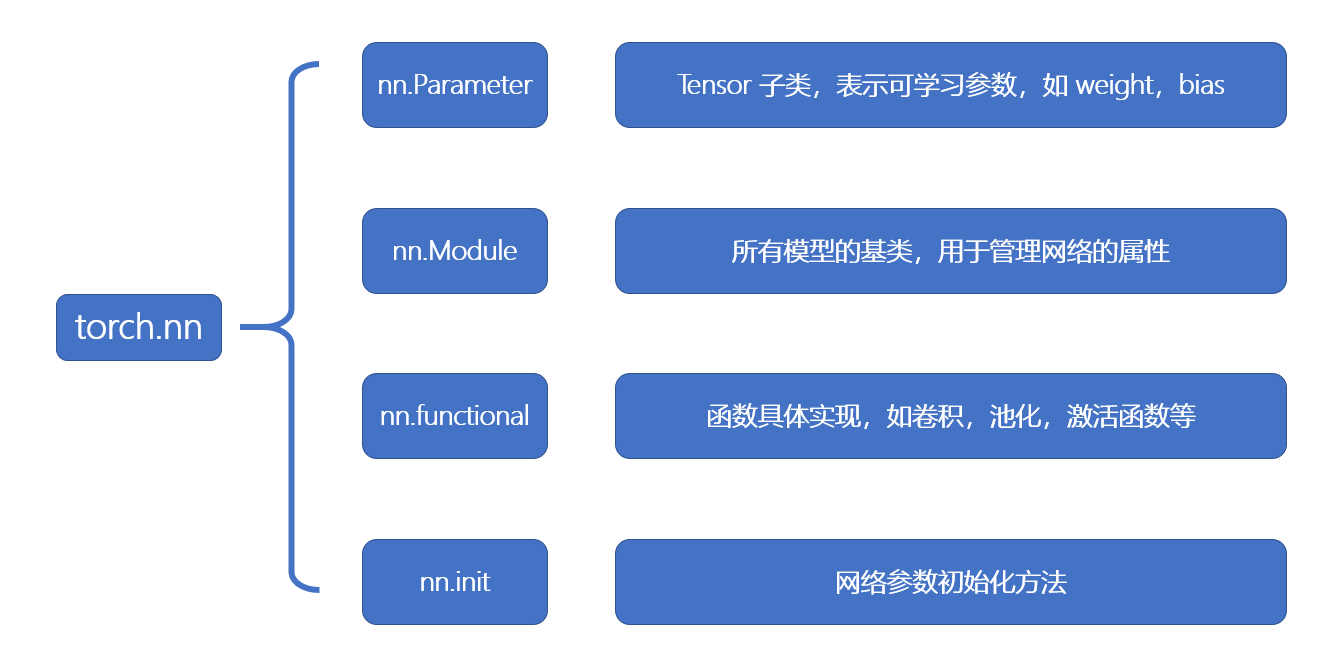

## Module 初认识

深度学习通常通过深度神经网络实现，这些网络由多个层组成，我们通常称之为模型（Model）。一个模型包含很多个网络层，多个网络层拼接构建成一个模型。在 PyTorch 中，模型是一个 Module，各网络层、模块也是 Module。本小节就介绍模型/模块的抽象——Module。后续不加以说明的话，模型、模块、网络层都可指代 Module。

Module 是所有神经网络的基类，所有的模型都必须继承于 Module 类，并且它可以嵌套，一个 Module 里可以包含另外一个 Module。要想理解清楚这句话就必须清楚了解一个 Module 是如何工作的。其实 Module 定义了一系列属性来管理模块的功能，分别用 8 个有序字典进行管理，分别是：

```python
self._modules = OrderedDict()
self._parameters = OrderedDict()
self._buffers = OrderedDict()
self._backward_hooks = OrderedDict()
self._forward_hooks = OrderedDict()
self._forward_pre_hooks = OrderedDict()
self._state_dict_hooks = OrderedDict()
self._load_state_dict_pre_hooks = OrderedDict()
```

它们的作用分别是：

- **modules**: 存储管理 nn.Module 类
- **parameters**: 存储管理 nn.Parameter 类
- **buffers**：存储管理缓冲属性，如 BN 层中的 running_mean
- **\_hooks**：存储管理钩子函数

 Module 有这些关键属性用于管理 Module，以及在哪里找到它们——debug 模式下的 Protected Attributes 看到它们的详情。
 
除了八大核心属性之外，还有一个函数不得不了解，那就是**forward函数**，forward之于Module等价于getitem之于Dataset。forward函数是模型每次调用的具体实现，所有的模型必须实现forward函数，否则调用时会报错

到这里，总结一下 Module：  

- **Module 是所有模型的基类**  
- **每个 Module 有 8 个字典管理它的核心属性**  
- **一个 Module 可以包含多个子 Module**  
- **一个 Module 相当于一个运算，必须实现 `forward` 函数**

一个模型的创建需要考虑两个要素：  

1. **构建子模块**：构建网络所需要的网络层，如卷积层，池化层，全连接层等等。  
2. **拼接子模块**：在 `forward` 函数中定义需要执行的功能，即将子模块以一定的方式拼接起来，完成对数据的前向传播。  

模型的创建就像搭积木，首先收集到需要的基础部件，是三角形、正方形还是六边形，然后以一定的方式拼接起来。如果要一个屋子，就先放正方形，然后放三角形。如果需要一个汽车，就先放两个圆形，再放一个长方形。  

同理，模型搭建也是。先知道有哪些网络层是需要的，那么在 `__init__` 函数里进行初始化，先让此类获得这些网络层可用。具体如何用，需要在 `forward` 函数中写清楚。就像下面这个图一样。  
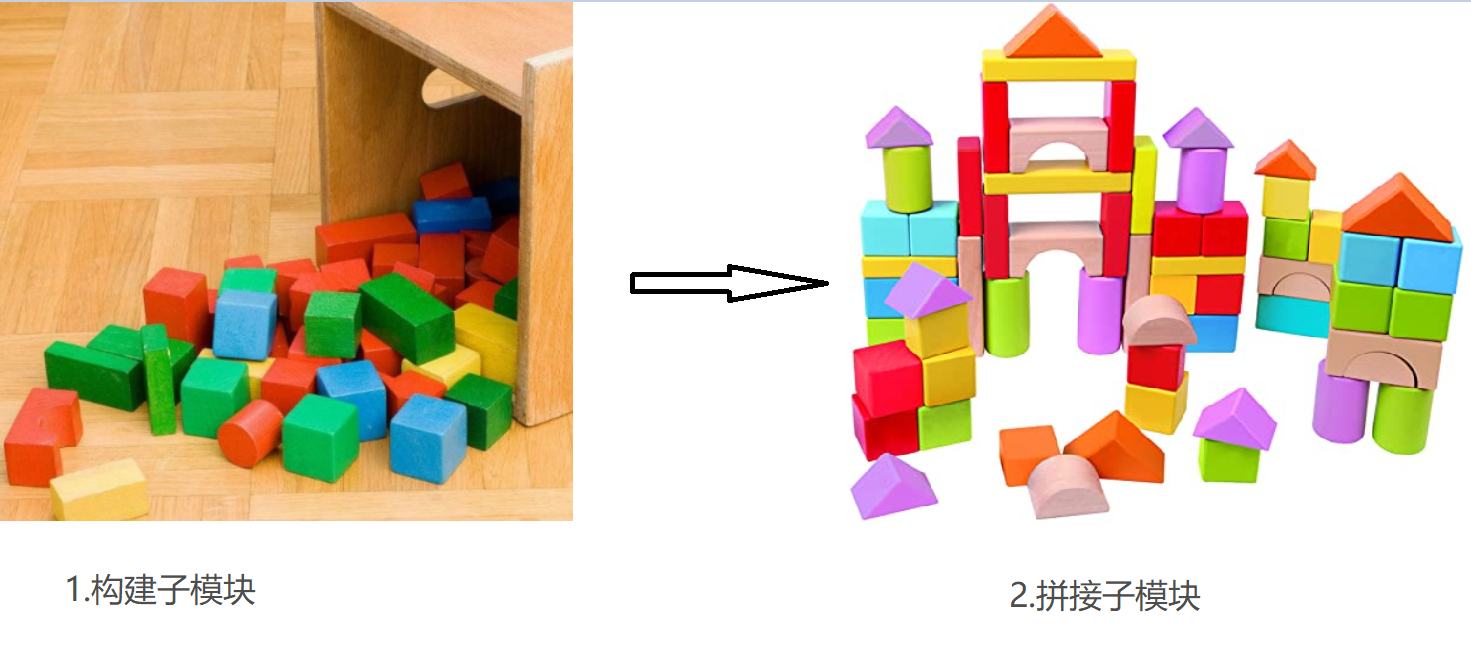

### nn.Module
要想直观地了解块是如何工作的，最简单的方法就是自己实现一个。 在实现我们自定义块之前，我们简要总结一下每个块必须提供的基本功能。
- 将输入数据作为其前向传播函数的参数。  

- 通过前向传播函数来生成输出。请注意，输出的形状可能与输入的形状不同。

- 计算其输出关于输入的梯度，可通过其反向传播函数进行访问。通常这是自动发生的。  

- 存储和访问前向传播计算所需的参数。  

- 根据需要初始化模型参数。  

在下面的代码片段中，我们从零开始编写一个块。它包含一个多层感知机，其具有256个隐藏单元的隐藏层和一个10维输出层。注意，下面的MLP类继承了表示块的类。我们的实现只需要提供我们自己的构造函数（Python中的`__init__`函数）和前向传播函数。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F


class MLP(nn.Module):
    # 用模型参数声明层。这里，我们声明两个全连接的层
    def __init__(self):
        # 调用MLP的父类Module的构造函数来执行必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params（稍后将介绍）
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # 隐藏层
        self.out = nn.Linear(256, 10)  # 输出层

    # 定义模型的前向传播，即如何根据输入X返回所需的模型输出
    def forward(self, X):
        # 注意，这里我们使用ReLU的函数版本，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(X)))

<span style="color:darkblue; font-size:18px;">  
看一下前向传播函数，它以X作为输入，计算带有激活函数的隐藏表示，并输出其未规范化的输出值。在这个MLP实现中，两个层都是实例变量。要了解这为什么是合理的，可以想象实例化两个多层感知机（net1和net2），并根据不同的数据对它们进行训练。当然，我们希望它们学到两种不同的模型。  
</span>  
<br>  
<span style="color:darkgreen; font-size:18px;">  
接着我们实例化多层感知机的层，然后在每次调用前向传播函数时调用这些层。注意一些关键细节：<br>
 首先，我们定制的__init__函数通过super().__init__() 调用父类的__init__函数，省去了重复编写模版代码的痛苦。<br>
 然后，我们实例化两个全连接层，分别为self.hidden和self.out。注意，除非我们实现一个新的运算符，否则我们不必担心反向传播函数或参数初始化，系统将自动生成这些。  <br>
块的一个主要优点是它的多功能性。 我们可以子类化块以创建层（如全连接层的类）、 整个模型（如上面的MLP类）或具有中等复杂度的各种组件。
</span>  
<br>  
<span style="color:darkred; font-size:18px;">  
我们来试一下这个函数：  
</span>

In [2]:
X = torch.rand(2, 20)
net = MLP()
net(X)

tensor([[ 0.2549,  0.0947, -0.1206, -0.0551, -0.0385,  0.0831,  0.0330, -0.1255,
          0.0284, -0.3361],
        [ 0.2569,  0.0380,  0.0363, -0.0246, -0.1209,  0.2040,  0.0778, -0.0493,
         -0.0057, -0.1786]], grad_fn=<AddmmBackward0>)

注意，这里并没有将 Module 类命名为 Layer (层)或者 Model (模型)之类的名字，这是因为该类是一个可供⾃由组建的部件。它的子类既可以是⼀个层(如PyTorch提供的 Linear 类)，⼜可以是一个模型(如这里定义的 MLP 类)，或者是模型的⼀个部分。

#### 不含模型参数的层  

我们先介绍如何定义一个不含模型参数的自定义层。下面构造的 `MyLayer` 类通过继承 `Module` 类自定义了一个将输入减掉均值后输出的层，并将层的计算定义在了 `forward` 函数里。这个层里不含模型参数。

In [5]:
import torch
from torch import nn

class MyLayer(nn.Module):
    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)
    def forward(self, x):
        return x - x.mean()  
layer = MyLayer()
layer(torch.tensor([1, 2, 3, 4, 5], dtype=torch.float))

tensor([-2., -1.,  0.,  1.,  2.])

#### 含模型参数的层  

我们还可以自定义含模型参数的自定义层。其中的模型参数可以通过训练学出。  

`Parameter` 类其实是 `Tensor` 的子类，如果一个 `Tensor` 是 `Parameter`，那么它会自动被添加到模型的参数列表里。所以在自定义含模型参数的层时，我们应该将参数定义成 `Parameter`，除了直接定义成 `Parameter` 类外，还可以使用 `ParameterList` 和 `ParameterDict` 分别定义参数的列表和字典。

In [6]:
class MyListDense(nn.Module):
    def __init__(self):
        super(MyListDense, self).__init__()
        self.params = nn.ParameterList([nn.Parameter(torch.randn(4, 4)) for i in range(3)])
        self.params.append(nn.Parameter(torch.randn(4, 1)))

    def forward(self, x):
        for i in range(len(self.params)):
            x = torch.mm(x, self.params[i])
        return x
net = MyListDense()
print(net)

MyListDense(
  (params): ParameterList(
      (0): Parameter containing: [torch.float32 of size 4x4]
      (1): Parameter containing: [torch.float32 of size 4x4]
      (2): Parameter containing: [torch.float32 of size 4x4]
      (3): Parameter containing: [torch.float32 of size 4x1]
  )
)


In [7]:
class MyDictDense(nn.Module):
    def __init__(self):
        super(MyDictDense, self).__init__()
        self.params = nn.ParameterDict({
                'linear1': nn.Parameter(torch.randn(4, 4)),
                'linear2': nn.Parameter(torch.randn(4, 1))
        })
        self.params.update({'linear3': nn.Parameter(torch.randn(4, 2))}) # 新增

    def forward(self, x, choice='linear1'):
        return torch.mm(x, self.params[choice])

net = MyDictDense()
print(net)

MyDictDense(
  (params): ParameterDict(
      (linear1): Parameter containing: [torch.FloatTensor of size 4x4]
      (linear2): Parameter containing: [torch.FloatTensor of size 4x1]
      (linear3): Parameter containing: [torch.FloatTensor of size 4x2]
  )
)


### Module容器——Containers  
 

在深度学习模型里面，有一些网络层需要放在一起使用，如 `conv + bn + relu` 的组合。`Module` 的容器是将一组操作捆绑在一起的工具，在 PyTorch 官方文档中把 `Module` 也定义为 Containers，或许是因为“Modules can also contain other Modules”。  

这里详细介绍两个常用的容器 `Sequential` 与 `ModuleList`，同时介绍 `ModuleDict`，`ParameterList`，`ParameterDict`。  
- `nn.Sequential`：按照顺序包装多个网络层  

- `nn.ModuleList`：像 Python 的 list 一样包装多个网络层，可以迭代  

- `nn.ModuleDict`：像 Python 的 dict 一样包装多个网络层，通过 (key, value) 的方式为每个网络层指定名称。

#### Sequential  

`Sequential` 是 PyTorch 里使用最广泛的容器，它的作用是将一系列网络层按固定的先后顺序串起来，当成一个整体，调用时数据从第一个层按顺序执行到最后一个层。  

`Sequential` 可以直接传 `module`，也可以传 `OrderedDict`。`OrderedDict` 可以让容器里的每个 `module` 都有名字，方便调用。  

请看两段官方代码：

In [ ]:
model = nn.Sequential(
          nn.Conv2d(1,20,5),
          nn.ReLU(),
          nn.Conv2d(20,64,5),
          nn.ReLU()
        )

# Using Sequential with OrderedDict. This is functionally the
# same as the above code
model = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(1,20,5)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(20,64,5)),
          ('relu2', nn.ReLU())
        ]))

**nn.Sequetial** 

在传统的机器学习中，有一个步骤是特征工程，我们需要从数据中认为地提取特征，然后把特征输入到分类器中预测。在深度学习的时代，特征工程的概念被弱化了，特征提取和分类器这两步被融合到了一个神经网络中。在卷积神经网络中，前面的卷积层以及池化层可以认为是特征提取部分，而后面的全连接层可以认为是分类器部分。比如 LeNet 就可以分为特征提取和分类器两部分，这 2 部分都可以分别使用 nn.Seuqtial 来包装。

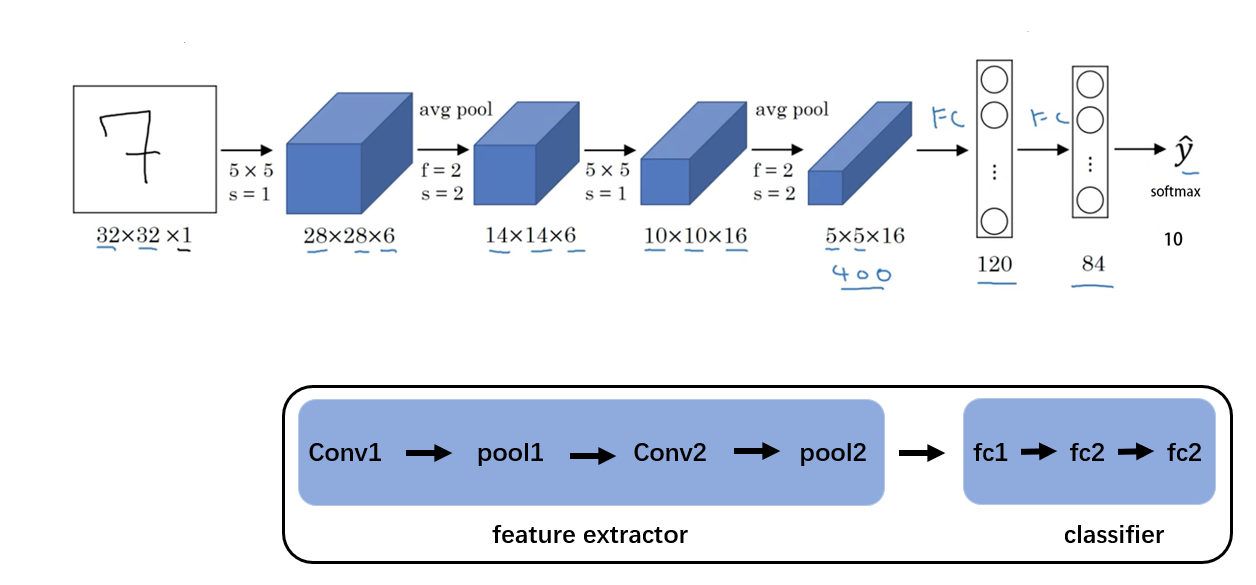

In [8]:
class LeNetSequetial(nn.Module):
    def __init__(self, classes):
        super(LeNet2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

在初始化时，nn.Sequetial会调用__init__()方法，将每一个子 module 添加到 自身的_modules属性中。这里可以看到，我们传入的参数可以是一个 list，或者一个 OrderDict。如果是一个 OrderDict，那么则使用 OrderDict 里的 key，否则使用数字作为 key (OrderDict 的情况会在下面提及)。
 ```python
   def __init__(self, *args):
        super(Sequential, self).__init__()
        if len(args) == 1 and isinstance(args[0], OrderedDict):
            for key, module in args[0].items():
                self.add_module(key, module)
        else:
            for idx, module in enumerate(args):
                self.add_module(str(idx), module)

```
网络初始化完成后有两个子 module：features和classifier。

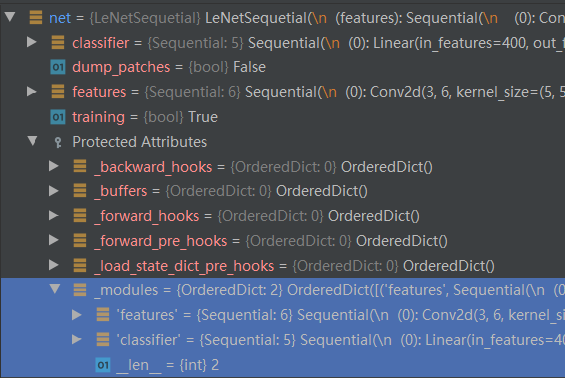

而features中的子 module 如下，每个网络层以序号作为 key：

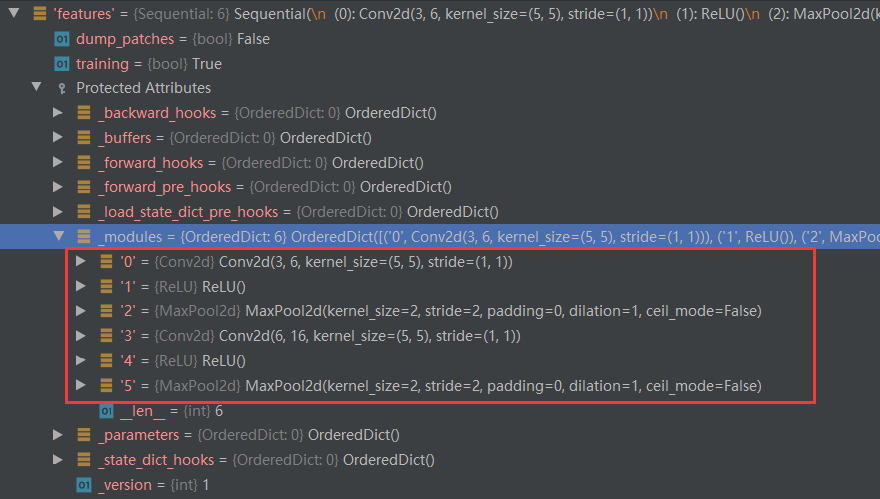

在进行前向传播时，会进入 LeNet 的 `forward()` 函数，首先调用第一个 `Sequential` 容器：`self.features`，由于 `self.features` 也是一个 module，因此会调用 `__call__()` 函数，里面调用  

`result = self.forward(*input, **kwargs)`，进入 `nn.Sequential` 的 `forward()` 函数，在这里依次调用所有的 module。  

```python  
def forward(self, input):  
    for module in self:  
        input = module(input)  
    return input
```
在上面可以看到在 nn.Sequential 中，里面的每个子网络层 module 是使用序号来索引的，即使用数字来作为 key。一旦网络层增多，难以查找特定的网络层，这种情况可以使用 OrderedDict (有序字典)。代码中使用


In [9]:
class LeNetSequentialOrderDict(nn.Module):
    def __init__(self, classes):
        super(LeNetSequentialOrderDict, self).__init__()

        self.features = nn.Sequential(OrderedDict({
            'conv1': nn.Conv2d(3, 6, 5),
            'relu1': nn.ReLU(inplace=True),
            'pool1': nn.MaxPool2d(kernel_size=2, stride=2),

            'conv2': nn.Conv2d(6, 16, 5),
            'relu2': nn.ReLU(inplace=True),
            'pool2': nn.MaxPool2d(kernel_size=2, stride=2),
        }))

        self.classifier = nn.Sequential(OrderedDict({
            'fc1': nn.Linear(16*5*5, 120),
            'relu3': nn.ReLU(),

            'fc2': nn.Linear(120, 84),
            'relu4': nn.ReLU(inplace=True),

            'fc3': nn.Linear(84, classes),
        }))
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

**小结**

nn.Sequetial是nn.Module的容器，用于按顺序包装一组网络层，有以下两个特性。

- 顺序性：各网络层之间严格按照顺序构建，我们在构建网络时，一定要注意前后网络层之间输入和输出数据之间的形状是否匹配

- 自带forward()函数：在nn.Sequetial的forward()函数里通过 for 循环依次读取每个网络层，执行前向传播运算。这使得我们我们构建的模型更加简洁

#### nn.ModuleList 

`nn.ModuleList` 是 `nn.Module` 的容器，用于包装一组网络层，以迭代的方式调用网络层，主要有以下 3 个方法：  

- `append()`：在 `ModuleList` 后面添加网络层  

- `extend()`：拼接两个 `ModuleList`  

- `insert()`：在 `ModuleList` 的指定位置中插入网络层  

下面的代码通过列表生成式来循环迭代创建 20 个全连接层，非常方便，只是在 `forward()` 函数中需要手动调用每个网络层。

In [10]:
class ModuleList(nn.Module):
    def __init__(self):
        super(ModuleList, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(10, 10) for i in range(20)])

    def forward(self, x):
        for i, linear in enumerate(self.linears):
            x = linear(x)
        return x


net = ModuleList()

print(net)

fake_data = torch.ones((10, 10))

output = net(fake_data)

print(output)

ModuleList(
  (linears): ModuleList(
    (0-19): 20 x Linear(in_features=10, out_features=10, bias=True)
  )
)
tensor([[ 0.3622,  0.0131, -0.0137, -0.3166, -0.1670,  0.0754,  0.2130, -0.1054,
          0.1381, -0.1604],
        [ 0.3622,  0.0131, -0.0137, -0.3166, -0.1670,  0.0754,  0.2130, -0.1054,
          0.1381, -0.1604],
        [ 0.3622,  0.0131, -0.0137, -0.3166, -0.1670,  0.0754,  0.2130, -0.1054,
          0.1381, -0.1604],
        [ 0.3622,  0.0131, -0.0137, -0.3166, -0.1670,  0.0754,  0.2130, -0.1054,
          0.1381, -0.1604],
        [ 0.3622,  0.0131, -0.0137, -0.3166, -0.1670,  0.0754,  0.2130, -0.1054,
          0.1381, -0.1604],
        [ 0.3622,  0.0131, -0.0137, -0.3166, -0.1670,  0.0754,  0.2130, -0.1054,
          0.1381, -0.1604],
        [ 0.3622,  0.0131, -0.0137, -0.3166, -0.1670,  0.0754,  0.2130, -0.1054,
          0.1381, -0.1604],
        [ 0.3622,  0.0131, -0.0137, -0.3166, -0.1670,  0.0754,  0.2130, -0.1054,
          0.1381, -0.1604],
        [ 0.3622,

#### nn.ModuleDict

`nn.ModuleDict` 是 `nn.Module` 的容器，用于包装一组网络层，以索引的方式调用网络层，主要有以下 5 个方法：  

- `clear()`：清空 `ModuleDict`  

- `items()`：返回可迭代的键值对 (key, value)  

- `keys()`：返回字典的所有 key  

- `values()`：返回字典的所有 value  

- `pop()`：返回一对键值，并从字典中删除  

下面的模型创建了两个 `ModuleDict`：`self.choices` 和 `self.activations`，在前向传播时通过传入对应的 key 来执行对应的网络层。

In [11]:
class ModuleDict(nn.Module):
    def __init__(self):
        super(ModuleDict, self).__init__()
        self.choices = nn.ModuleDict({
            'conv': nn.Conv2d(10, 10, 3),
            'pool': nn.MaxPool2d(3)
        })

        self.activations = nn.ModuleDict({
            'relu': nn.ReLU(),
            'prelu': nn.PReLU()
        })

    def forward(self, x, choice, act):
        x = self.choices[choice](x)
        x = self.activations[act](x)
        return x


net = ModuleDict()

fake_img = torch.randn((4, 10, 32, 32))

output = net(fake_img, 'conv', 'relu')
# output = net(fake_img, 'conv', 'prelu')
print(output)

tensor([[[[0.0000e+00, 0.0000e+00, 3.3199e-02,  ..., 6.6341e-01,
           0.0000e+00, 6.0867e-01],
          [8.5478e-01, 0.0000e+00, 5.0733e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.2837e-01, 5.8030e-01, 0.0000e+00,  ..., 5.3822e-01,
           0.0000e+00, 1.4692e-01],
          ...,
          [7.9179e-02, 1.1463e-01, 7.3098e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0193e+00, 0.0000e+00, 0.0000e+00,  ..., 9.9255e-01,
           1.9570e-03, 5.2151e-02],
          [0.0000e+00, 3.1245e-01, 5.2151e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 8.8207e-01, 8.2163e-02,  ..., 2.0337e-02,
           4.3540e-02, 5.3687e-01],
          [0.0000e+00, 3.5035e-01, 2.3068e-01,  ..., 0.0000e+00,
           4.0045e-01, 0.0000e+00],
          [2.6318e-01, 0.0000e+00, 6.0178e-01,  ..., 0.0000e+00,
           4.7667e-01, 0.0000e+00],
          ...,
          [0.0000e+00, 4.5991e-01, 5.8529e-01,  ..., 1.1944

- `nn.Sequential`：顺序性，各网络层之间严格按照顺序执行，常用于 block 构建，在前向传播时的代码调用变得简洁  

- `nn.ModuleList`：迭代性，常用于大量重复网络构建，通过 for 循环实现重复构建  

- `nn.ModuleDict`：索引性，常用于可选择的网络层

## 网络参数管理
本节，我们将介绍以下内容：

- 访问参数，用于调试、诊断和可视化；

- 参数初始化；

- 在不同模型组件间共享参数。

先看一下具有单隐藏层的多层感知机。

In [13]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[0.3989],
        [0.3459]], grad_fn=<AddmmBackward0>)

### 参数访问
从已有模型中访问参数。 当通过Sequential类定义模型时， 可以通过索引来访问模型的任意层。 这就像模型是一个列表一样，每层的参数都在其属性中。 如下所示，可以检查第二个全连接层的参数。

In [21]:
print(net[2].state_dict())

OrderedDict({'weight': tensor([[ 0.3073, -0.2536, -0.1053, -0.2487,  0.3387,  0.2319, -0.2675, -0.1998]]), 'bias': tensor([0.1061])})


**目标参数**

每个参数都表示为参数类的一个实例。 要对参数执行任何操作，首先需要访问底层的数值。 有几种方法可以做到这一点。下面的代码从第二个全连接层（即第三个神经网络层）提取偏置， 提取后返回的是一个参数类实例，并进一步访问该参数的值。

参数是复合的对象，包含值、梯度和额外信息。 这就是我们需要显式参数值的原因。 除了值之外，我们还可以访问每个参数的梯度。 在上面这个网络中，由于我们还没有调用反向传播，所以参数的梯度处于初始状态。

In [16]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)
net[2].weight.grad == None

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.1061], requires_grad=True)
tensor([0.1061])


True

**一次性访问所有参数**

当需要对所有参数执行操作时，逐个访问它们可能会很麻烦。 当处理更复杂的块（例如，嵌套块）时，情况可能会变得特别复杂， 因为我们需要递归整个树来提取每个子块的参数。 下面，通过演示来比较访问第一个全连接层的参数和访问所有层。


In [17]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


**从嵌套块收集参数**

如果将多个块相互嵌套，参数命名约定是如何工作的。 首先定义一个生成块的函数（可以说是“块工厂”），然后将这些块组合到更大的块中。

In [19]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # 在这里嵌套
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


因为层是分层嵌套的，所以我们也可以像通过嵌套列表索引一样访问它们。 下面，我们访问第一个主要的块中、第二个子块的第一层的偏置项。

In [20]:
rgnet[0][1][0].bias.data

tensor([ 0.3871,  0.4685,  0.4842,  0.3226, -0.0187, -0.4587,  0.4199, -0.4478])

### 参数初始化  

知道了如何访问参数后，现在看看如何正确地初始化参数。深度学习框架提供默认随机初始化，也允许我们创建自定义初始化方法，满足我们通过其他规则实现初始化权重。  

默认情况下，PyTorch 会根据一个范围均匀地初始化权重和偏置矩阵，这个范围是根据输入和输出维度计算出的。PyTorch 的 `nn.init` 模块提供了多种预置初始化方法。

**内置初始化**
  
首先调用内置的初始化器。 下面的代码将所有权重参数初始化为标准差为0.01的高斯随机变量， 且将偏置参数设置为0。

In [22]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0066,  0.0059,  0.0210,  0.0097]), tensor(0.))

还可以将所有参数初始化为给定的常数，比如初始化为1。

In [23]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

还可以对某些块应用不同的初始化方法。 例如，下面我们使用Xavier初始化方法初始化第一个神经网络层， 然后将第三个神经网络层初始化为常量值42。

In [24]:
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([ 0.3227, -0.6689, -0.4019, -0.0893])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


**自定义初始化** 

有时，深度学习框架没有提供我们需要的初始化方法。在下面的例子中，我们使用以下的分布为任意权重参数 \( w \) 定义初始化方法：  

$  
w \sim   
\begin{cases}  
U(5, 10) & \text{可能性 } \frac{1}{4} \\
0 & \text{可能性 } \frac{1}{2} \\
U(-10, -5) & \text{可能性 } \frac{1}{4} \\
\end{cases}  
$ 

同样，我们实现了一个my_init函数来应用到net。

In [25]:
def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[ 0.0000, -9.0085, -0.0000,  0.0000],
        [-7.7724,  0.0000, -7.1935,  7.6894]], grad_fn=<SliceBackward0>)

如果不满足要求，我们还可以直接设置参数。

In [26]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000, -8.0085,  1.0000,  1.0000])

### 参数绑定

有时希望在多个层间共享参数： 可以定义一个稠密层，然后使用它的参数来设置另一个层的参数。

In [27]:
# 我们需要给共享层一个名称，以便可以引用它的参数
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)
# 检查参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# 确保它们实际上是同一个对象，而不只是有相同的值
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


第三个和第五个神经网络层的参数是绑定的。 它们不仅值相等，而且由相同的张量表示。 因此，如果我们改变其中一个参数，另一个参数也会改变。 

这里有一个问题：**当参数绑定时，梯度会发生什么情况？**

答案是由于模型参数包含梯度，因此在反向传播期间第二个隐藏层 （即第三个神经网络层）和第三个隐藏层（即第五个神经网络层）的梯度会加在一起。

### 加载和保存模型参数

如果我们想保存整个模型，并在以后加载它们。 需要注意的一个重要细节是，这将保存模型的参数而不是保存整个模型。

例如，如果我们有一个3层多层感知机，我们需要单独指定架构。 因为模型本身可以包含任意代码，所以模型本身难以序列化。 因此，为了恢复模型，我们需要用代码生成架构， 然后从磁盘加载参数。 让我们从熟悉的多层感知机开始尝试一下。

In [28]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

接下来，我们将模型的参数存储在一个叫做“mlp.params”的文件中。

In [29]:
torch.save(net.state_dict(), 'mlp.params')

为了恢复模型，我们实例化了原始多层感知机模型的一个备份。 这里我们不需要随机初始化模型参数，而是直接读取文件中存储的参数。

In [30]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

/var/folders/z2/s5q05z8n4537pyvqd1m5yq9h0000gp/T/ipykernel_536/2014828273.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clone.load_state_dict(torch.load('mlp.params'))

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

两个实例具有相同的模型参数，在输入相同的X时， 两个实例的计算结果应该相同。 让我们来验证一下。

In [31]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

## 常用网络层
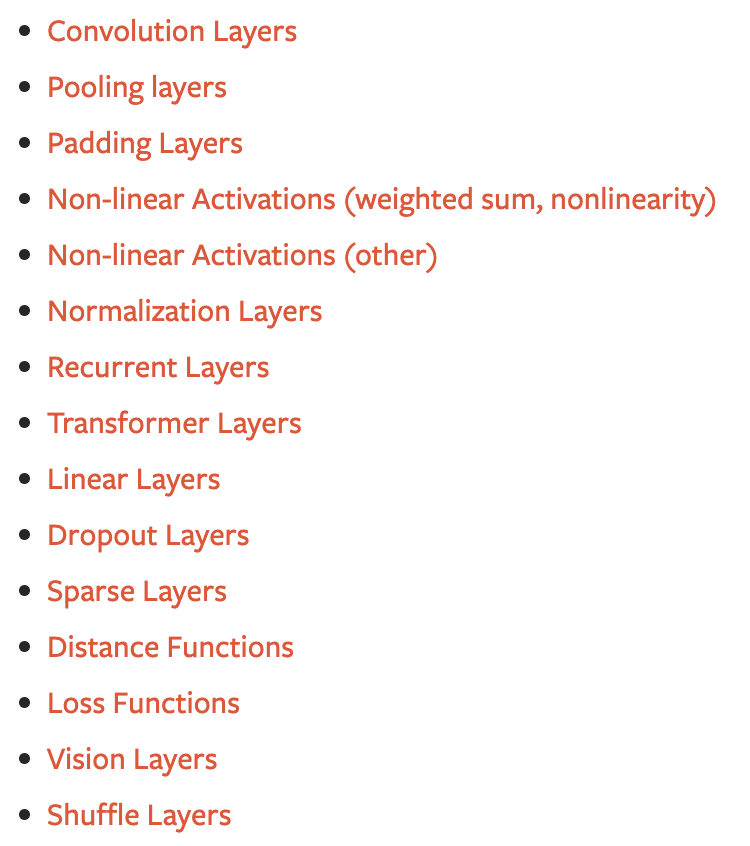

二维卷积层
池化层
Linear：全连接层；
BatchNorm：批标准化层，分为1D、2D和3D。除了标准的BatchNorm之外，还有在风格迁移中常用到的InstanceNorm层；
Dropout：Dropout层，用来防止过拟合，同样分为1D、2D和3D。
Transformer

### 二维卷积层

在深度学习中，与图像处理相关的网络结构中最重要的便是卷积层（Conv）。卷积神经网络的本质就是卷积层、池化层、激活层以及其他层的叠加，因此理解卷积层的工作原理是极其重要的。本节将以最常见的二维卷积为例来对卷积层进行说明。

在 `torch.nn` 工具箱中，已经封装好了二维卷积类：

```python
torch.nn.Conv2d(in_channels: int,   
                out_channels: int,  
                kernel_size: Union[T, Tuple[T, T]], 
                stride: Union[T, Tuple[T, T]] = 1, 
                padding: Union[T, Tuple[T, T]] = 0, 
                dilation: Union[T, Tuple[T, T]] = 1, 
                groups: int = 1, bias: bool = True, 
                padding_mode: str = 'zeros')
```

其中：

- `in_channels`：输入图像的维度（常见 RGB 彩色图像为 3）；
- `out_channels`：经过卷积操作后输出的维度；
- `kernel_size`：卷积核大小，常见卷积核为 2 维方阵，即维度为 \([ T \times T ]\)，正方形卷积核可以写为 \( T \) (`int`)；
- `stride`：每次卷积操作移动的步长；
- `padding`：卷积操作在边界是否有填充，默认为 0；
- `bias`：卷积操作加上偏置作为可学习参数，默认为 `True`。

  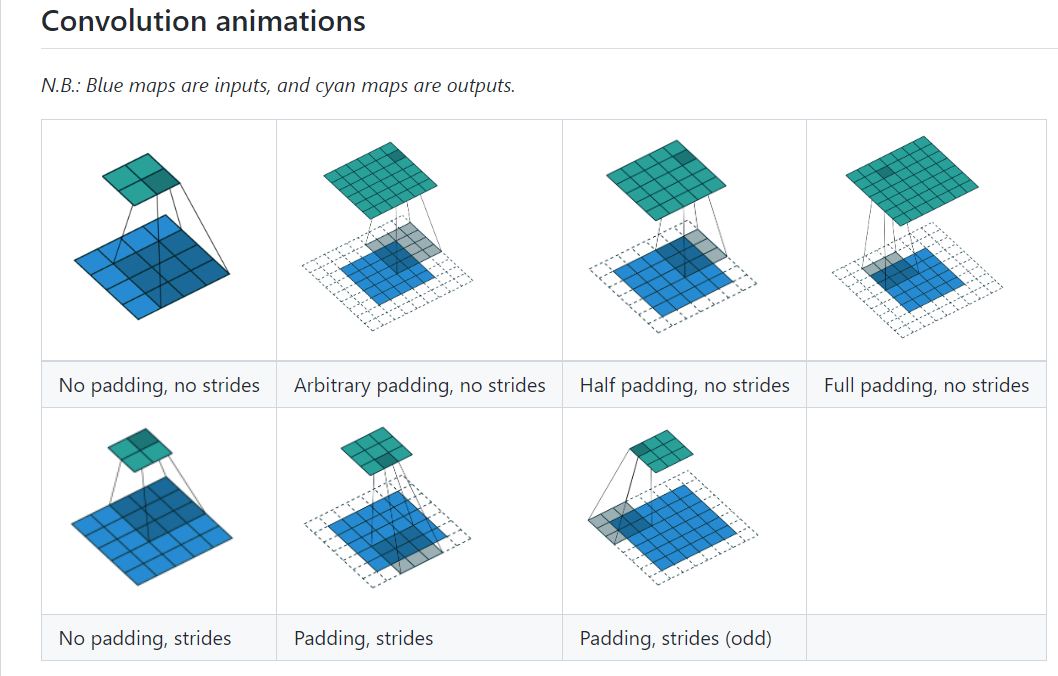

在卷积操作中，我们需要知道其输出结果的形状，以便对后续网络结构进行设计。假设输入的形状为 \(( N, C_{in}, H_{in}, W_{in} )\)，输出的形状为 \(( N, C_{out}, H_{out}, W_{out} )\)，则可以通过公式(1)计算：

$
H_{out} = \left\lfloor \frac{H_{in} + 2 \times \text{padding}[0] - \text{kernel\_size}[0]}{\text{stride}[0]} + 1 \right\rfloor
$

$
W_{out} = \left\lfloor \frac{W_{in} + 2 \times \text{padding}[1] - \text{kernel\_size}[1]}{\text{stride}[1]} + 1 \right\rfloor
$

下面将举例说明卷积操作的具体过程。


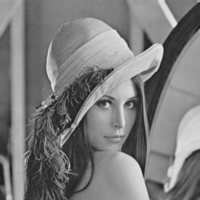

In [11]:
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import torch as t
from torch import nn
to_tensor = ToTensor() # img -> tensor
to_pil = ToPILImage()
lena = Image.open('./lena.png')
lena#将lena可视化输出

Input Size: torch.Size([1, 1, 200, 200])
Output Size: torch.Size([1, 1, 198, 198])


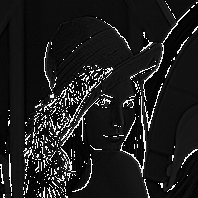

In [7]:
# 输入是一个batch，batch_size＝1
lena = to_tensor(lena).unsqueeze(0) 
print("Input Size:",lena.size())#查看input纬度
# 锐化卷积核
kernel = t.ones(3, 3) / (-9.)
kernel[1][1] = 1
conv = nn.Conv2d(1, 1, (3, 3), 1, bias=False)
conv.weight.data = kernel.view(1, 1, 3, 3)

out = conv(lena)
print("Output Size:",out.size())
to_pil(out.data.squeeze(0))

在上面的例子中，输入Tensor的大小为 200 × 200，卷积核大小为 3 × 3，步长为1，填充为0，则根据式(1)可以计算得到输出的形状为：  

$ H_{\text{out}} = W_{\text{out}} = \left\lfloor \frac{200 + 2 \times 0 - 3}{1} + 1 \right\rfloor = 198 $ 

这与程序输出的维度一致。  

这里我们以二维卷积为例对卷积层的输入输出进行了基本的介绍。除了二维卷积以外，图像的卷积操作还有各种变体，感兴趣的读者可以进一步查阅相关资料。  

### 池化层  

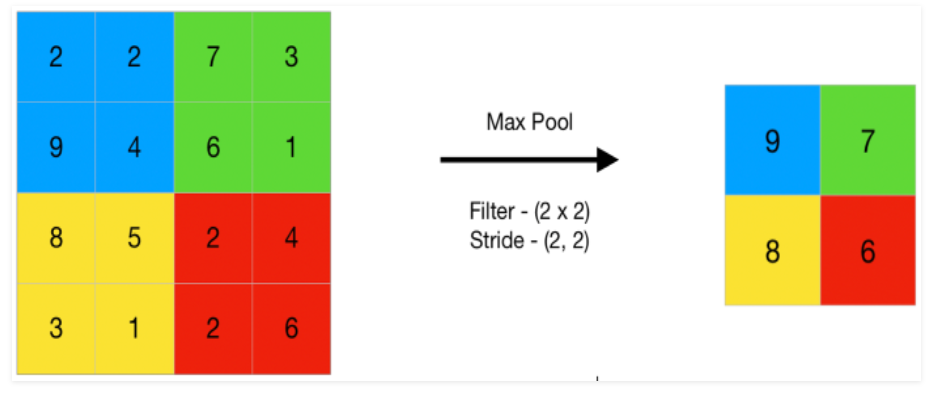

池化层可以看作是一种特殊的卷积层，其主要用于下采样，增加池化层可以在保留主要特征的同时降低参数量，从而一定程度上防止了过拟合。池化层没有可学习参数，它的weight是固定的。在torch.nn工具箱中封装好了各种池化层，常见的有最大池化（MaxPool）和平均池化（AvgPool)，下面将举例说明。

In [12]:
input = t.randint(10,(1,1,4,4))
print(input)
pool = nn.AvgPool2d(2,2) # 平均池化，池化中的卷积核为2*2，步长默认等于卷积核长度，无填充
pool(input)

tensor([[[[4, 1, 7, 0],
          [8, 2, 7, 9],
          [1, 6, 8, 4],
          [8, 8, 8, 1]]]])


tensor([[[[3, 5],
          [5, 5]]]])

In [13]:
list(pool.parameters()) # 可以看到，池化层中并没有可学习参数。

[]

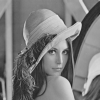

In [15]:
lena = to_tensor(lena).unsqueeze(0) 
out = pool(lena)
to_pil(out.data.squeeze(0))#输出池化后的lena

### 其他层
除了卷积层和池化层，深度学习中还将常用到以下几个层：

Linear：全连接层；
BatchNorm：批标准化层，分为1D、2D和3D。除了标准的BatchNorm之外，还有在风格迁移中常用到的InstanceNorm层；
Dropout：Dropout层，用来防止过拟合，同样分为1D、2D和3D。

### Linear Layers  

Linear Layers 包含4个层分别是 `nn.Identity`，`nn.Linear`， `nn.Bilinear`， `nn.LazyLinear`  

- **`nn.Identity`** 是恒等映射，不对输入做任何变换，它通常用于占位。  
  
- **`nn.Linear`** 就是大家熟悉的全连接层 (Fully Connection Layer)，可实现 \( y = Wx + b \)  

- **`nn.Bilinear`** 是双线性层，它有两个输入，实现公式 \( y = x1Wx2 + b \)  

- **`nn.LazyLinear`** 是 `nn.Linear` 的 lazy 版本，也就是懒惰的 Linear 层，它在第一次推理时自动根据输入特征图的尺寸来设定 `in_features`，免去了手动计算 `in_features` 的麻烦。  

Linear 层十分简单，就不用代码演示了。  

### Normalization Layers  

Normalization Layers 里包含主流的标准化网络层，分别有 BN、LN、IN、GN 以及早期的 LRN。这一些列的层已经成为现在深度学习模型的标配，它们充当一种正则，对数据的分布进行变换，使数据分布变到 0 均值，1 标准差的形式。实验结果发现这样做可以加速模型训练，让模型更稳定，精度更高。  

其中最出名的当属2015年提出的 BatchNorm, 来自于 Google 团队的 *Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift*，关于 BN 的介绍网上有很多文章，大家可自行学习，在代码实现上我们需要熟悉网络层内部的参数，以及训练与推理过程中的差异。  

BatchNorm 会对输入进行减均值、除以标准差、乘以 \( \gamma \)、加 \( \beta \) 的操作。如下图所示：  

其中 \( \gamma \) 与 \( \beta \) 是 `Parameter`，是可训练的参数，与卷积层的卷积核、FC 层的权重一样，容易理解。  

均值与标准差就没那么简单了，在训练过程，它们是通过指数移动平均统计得来，在测试时则是用固定的、不会再变化的均值和方差。  

从此也可知道，当模型设置在训练状态 (`model.train()`) 与推理状态 (`model.eval()`) 时，BN 层的操作输出是会不一样的。  

方法原型如下：  

```python  
torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)
```
下面将举几个例子来说明它们的使用方法。

In [16]:
# 输入 batch_size=2，维度3
input = t.randn(2, 3)
linear = nn.Linear(3, 4)
h = linear(input)
h

tensor([[ 0.8766, -1.2688, -0.7326,  0.9043],
        [ 0.8213, -0.0054, -0.1546,  0.5787]], grad_fn=<AddmmBackward0>)

In [17]:
# 4 channel，初始化标准差为4，均值为0
bn = nn.BatchNorm1d(4)
bn.weight.data = t.ones(4) * 4
bn.bias.data = t.zeros(4)

bn_out = bn(h)
print(bn_out)
# 注意输出的均值和方差
bn_out.mean(0),bn_out.std(0, unbiased=False)

tensor([[ 3.9741, -3.9999, -3.9998,  3.9992],
        [-3.9741,  3.9999,  3.9998, -3.9992]],
       grad_fn=<NativeBatchNormBackward0>)


(tensor([ 0.0000e+00,  2.3842e-07,  0.0000e+00, -9.5367e-07],
        grad_fn=<MeanBackward1>),
 tensor([3.9741, 3.9999, 3.9998, 3.9992], grad_fn=<StdBackward0>))

In [18]:
# 每个元素以0.5的概率随机舍弃
dropout = nn.Dropout(0.5)
o = dropout(bn_out)
o # 有一半左右的数变为0

tensor([[ 0.0000, -7.9999, -7.9995,  7.9985],
        [-0.0000,  0.0000,  7.9995, -0.0000]], grad_fn=<MulBackward0>)

以上很多例子中都对module的属性直接操作，其大多数是可学习参数，一般会随着学习的进行而不断改变。实际使用中除非需要使用特殊的初始化，否则应尽量不要直接修改这些参数。

### Transformer 层  

- **`nn.Transformer`**  

  一个 Transformer 模型。  

- **`nn.TransformerEncoder`**  

  `TransformerEncoder` 是由 N 个编码器层组成的栈。  

- **`nn.TransformerDecoder`**  

  `TransformerDecoder` 是由 N 个解码器层组成的栈。  

- **`nn.TransformerEncoderLayer`**  

  `TransformerEncoderLayer` 由自注意力 (self-attention, `self-attn`) 和前馈网络 (feedforward network) 组成。  

- **`nn.TransformerDecoderLayer`**  

  `TransformerDecoderLayer` 由自注意力 (self-attention, `self-attn`)、多头注意力 (multi-head attention, `multi-head-attn`)、和前馈网络 (feedforward network) 组成。

  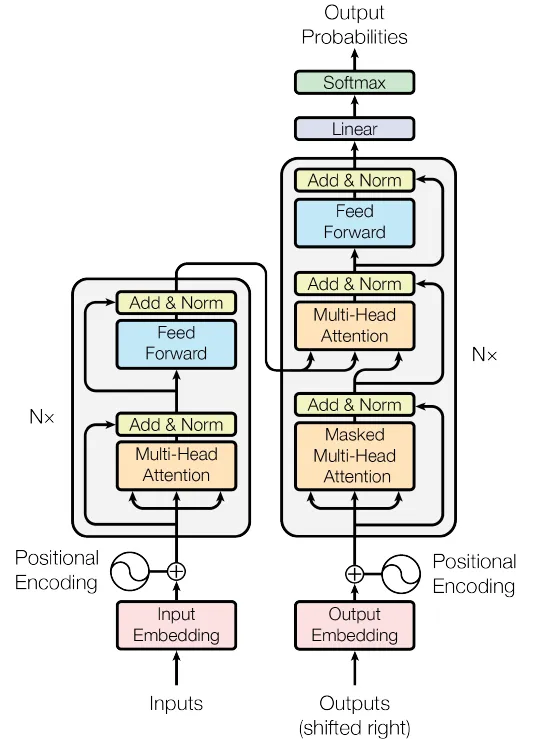

In [19]:
import torch  
import torch.nn as nn  
import torch.optim as optim  

# Define the dimensions  
d_model = 512  # Embedding size  
nhead = 8      # Number of attention heads  
num_layers = 6 # Number of encoder/decoder layers  

# Define a transformer model  
transformer_model = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers)  

# Create some sample data (randomly initialized for demonstration)  
src = torch.rand(10, 32, d_model)  # (sequence_length, batch_size, d_model)  
tgt = torch.rand(20, 32, d_model)  # (sequence_length, batch_size, d_model)  

# Perform a forward pass  
output = transformer_model(src, tgt)  

print("Transformer output shape:", output.shape)  

# Optionally, define a simple loss and optimizer  
criterion = nn.MSELoss()  
optimizer = optim.SGD(transformer_model.parameters(), lr=0.01)  

# Dummy target output  
target = torch.rand(20, 32, d_model)  

# Define a simple training loop  
for epoch in range(5):  # Small number of epochs for demonstration  
    optimizer.zero_grad()  
    output = transformer_model(src, tgt)  
    loss = criterion(output, target)  
    loss.backward()  
    optimizer.step()  
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

/opt/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer output shape: torch.Size([20, 32, 512])
Epoch 1, Loss: 1.3327324390411377
Epoch 2, Loss: 1.332303762435913
Epoch 3, Loss: 1.33237886428833
Epoch 4, Loss: 1.3321253061294556
Epoch 5, Loss: 1.332195520401001


In [20]:
import torch  
import torch.nn as nn  
import torch.optim as optim  

# Define the dimensions  
d_model = 512  # Embedding size  
nhead = 8      # Number of attention heads  
num_layers = 6 # Number of encoder layers  

# Define a single encoder layer  
encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)  

# Define the Transformer encoder with multiple layers  
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)  

# Create sample input data (randomly initialized for demonstration)  
src = torch.rand(10, 32, d_model)  # (sequence_length, batch_size, d_model)  

# Pass data through the Transformer encoder  
output = transformer_encoder(src)  

print("Encoder output shape:", output.shape)  

# Optionally, define a simple loss and optimizer for demonstration  
criterion = nn.MSELoss()  
optimizer = optim.SGD(transformer_encoder.parameters(), lr=0.01)  

# Dummy target output (same shape as encoder output)  
target = torch.rand(10, 32, d_model)  

# Define a simple training loop  
for epoch in range(5):  # Small number of epochs for demonstration  
    optimizer.zero_grad()  
    output = transformer_encoder(src)  
    loss = criterion(output, target)  
    loss.backward()  
    optimizer.step()  
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Encoder output shape: torch.Size([10, 32, 512])
Epoch 1, Loss: 1.3316400051116943
Epoch 2, Loss: 1.3303724527359009
Epoch 3, Loss: 1.3306230306625366
Epoch 4, Loss: 1.3305931091308594
Epoch 5, Loss: 1.3306388854980469


In [21]:
import torch  
import torch.nn as nn  
import torch.optim as optim  

# Define the dimensions  
d_model = 512  # Embedding size  
nhead = 8      # Number of attention heads  
num_layers = 6 # Number of decoder layers  

# Define a single decoder layer  
decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)  

# Define the Transformer decoder with multiple layers  
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)  

# Create sample input data for the target (randomly initialized for demonstration)  
tgt = torch.rand(20, 32, d_model)  # (tgt_sequence_length, batch_size, d_model)  

# Create sample memory data from the encoder (randomly initialized for demonstration)  
memory = torch.rand(10, 32, d_model)  # (memory_sequence_length, batch_size, d_model)  

# Pass data through the Transformer decoder  
output = transformer_decoder(tgt, memory)  

print("Decoder output shape:", output.shape)  

# Optionally, define a simple loss and optimizer for demonstration  
criterion = nn.MSELoss()  
optimizer = optim.SGD(transformer_decoder.parameters(), lr=0.01)  

# Dummy target output for training (same shape as decoder output)  
target = torch.rand(20, 32, d_model)  

# Define a simple training loop  
for epoch in range(5):  # Small number of epochs for demonstration  
    optimizer.zero_grad()  
    output = transformer_decoder(tgt, memory)  
    loss = criterion(output, target)  
    loss.backward()  
    optimizer.step()  
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Decoder output shape: torch.Size([20, 32, 512])
Epoch 1, Loss: 1.3339476585388184
Epoch 2, Loss: 1.3333097696304321
Epoch 3, Loss: 1.3336045742034912
Epoch 4, Loss: 1.3335015773773193
Epoch 5, Loss: 1.3329225778579712
